## Imports

In [173]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA
from tqdm import tqdm
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

from IPython.display import display

sns.set_style('whitegrid')

## Load Data

In [195]:
split_frac = 0.9
df = pd.read_csv('../processed_data/v3/BH_rf_impute.csv' , index_col='obs_id').sample(frac=1 , random_state=2)
train_bh = df.iloc[:int(len(df)*split_frac)]
test_bh = df.iloc[int(len(df)*split_frac):]

df = pd.read_csv('../processed_data/v3/CV_rf_impute.csv' , index_col='obs_id').sample(frac=1 ,  random_state=2)
train_cv = df.iloc[:int(len(df)*split_frac)]
test_cv = df.iloc[int(len(df)*split_frac):]

df = pd.read_csv('../processed_data/v3/NS_rf_impute.csv' , index_col='obs_id').sample(frac=1 ,  random_state=2)
train_ns = df.iloc[:int(len(df)*split_frac)]
test_ns = df.iloc[int(len(df)*split_frac):]

df = pd.read_csv('../processed_data/v3/PULSAR_rf_impute.csv' , index_col='obs_id').sample(frac=1 ,  random_state=2)
train_plsr = df.iloc[:int(len(df)*split_frac)]
test_plsr = df.iloc[int(len(df)*split_frac):]

inter_obs_params = ['var_inter_prob' , 'var_inter_index' , 'var_inter_sigma']

data = pd.concat([train_bh , train_ns , train_cv , train_plsr] , axis=0)
data = data.drop(columns=inter_obs_params)
train_data = data.copy()
train_data.to_csv('current_data/train_data.csv')


data = pd.concat([test_bh , test_ns , test_cv , test_plsr] , axis=0)
data = data.drop(columns=inter_obs_params)
test_data = data.copy()
test_data.to_csv('current_data/test_data.csv')


In [268]:

# enaable these two lines for NS-BH
train_data = pd.read_csv('current_data/train_data.csv' , index_col='obs_id')
test_data = pd.read_csv('current_data/test_data.csv' , index_col='obs_id')

train_data = train_data.replace('NS' , 'XRB')
train_data = train_data.replace('BH' , 'XRB')

test_data = test_data.replace('NS' , 'XRB')
test_data = test_data.replace('BH' , 'XRB')


class_to_select = ['XRB' , 'CV' , 'PULSAR']
data = train_data[train_data['class'].isin(class_to_select)]
#display(data)


In [271]:
info_col = [ 'class' , 'src_n' , 'src_id' , 'significance']
data_info = data[info_col]
data_val = data.drop(columns=info_col) 
data_label = data['class']

In [270]:
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier 
clf = RandomForestClassifier()

# Hyper Parameter Tuning

In [20]:
rfc_v2 = RandomForestClassifier()

## Random Search

In [21]:
from sklearn.model_selection import RandomizedSearchCV

In [22]:
n_estimators = [int(x) for x in np.linspace(80 , 800 , num=40)]
max_features = ['log2' , 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 150, num = 40)]
min_samples_split = [int(x) for x in np.linspace(2,20 ,num = 30)]
min_samples_leaf = [int(x) for x in np.linspace(2,30 , num = 30)]
bootstrap = [True , False]

In [23]:
params_dict = {
    'n_estimators' : n_estimators , 
    'max_features' : max_features ,
    'max_depth' :max_depth , 
    'min_samples_split' : min_samples_split , 
    'min_samples_leaf' : min_samples_leaf, 
    'bootstrap' : bootstrap 
}

In [24]:
rs = RandomizedSearchCV(
    rfc_v2 , 
    params_dict , 
    n_iter = 100,
    cv = 5 ,
    verbose = 5 ,
    n_jobs=-1 , 
    random_state= 0 
)

In [25]:
rs.fit(data_val , data_label)
rs.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'n_estimators': 135,
 'min_samples_split': 9,
 'min_samples_leaf': 30,
 'max_features': 'sqrt',
 'max_depth': 1,
 'bootstrap': False}

In [26]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                393                       6                     18   
1                135                       9                     30   
2                763                       9                      7   
3                523                      16                     26   
4                135                       9                     20   
5                 98                       8                     15   
6                596                      12                     30   
7                578                      18                     30   
8                578                      15                     12   
9                301                       6                     17   

  param_max_features param_max_depth param_bootstrap  split3_test_score  \
0               log2               1            True           0.397683   
1               sqrt               1           False           0.397683   
2               sqrt               1           False           0.397683   
3               sqrt               1           False           0.397683   
4               log2             123            True           0.335907   
5               sqrt              58            True           0.343629   
6               log2              65            True           0.328185   
7               sqrt              62            True           0.332046   
8               log2               4            True           0.351351   
9               sqrt             107            True           0.347490   

   split4_test_score  mean_test_score  rank_test_score  
0           0.399225         0.397992                1  
1           0.399225         0.397992                1  
2           0.399225         0.397992                1  
3           0.399225         0.397992                1  
4           0.387597         0.367867                5  
5           0.399225         0.367104                6  
6           0.403101         0.364790                7  
7           0.399225         0.364015                8  
8           0.395349         0.364012                9  
9           0.387597         0.364006               10

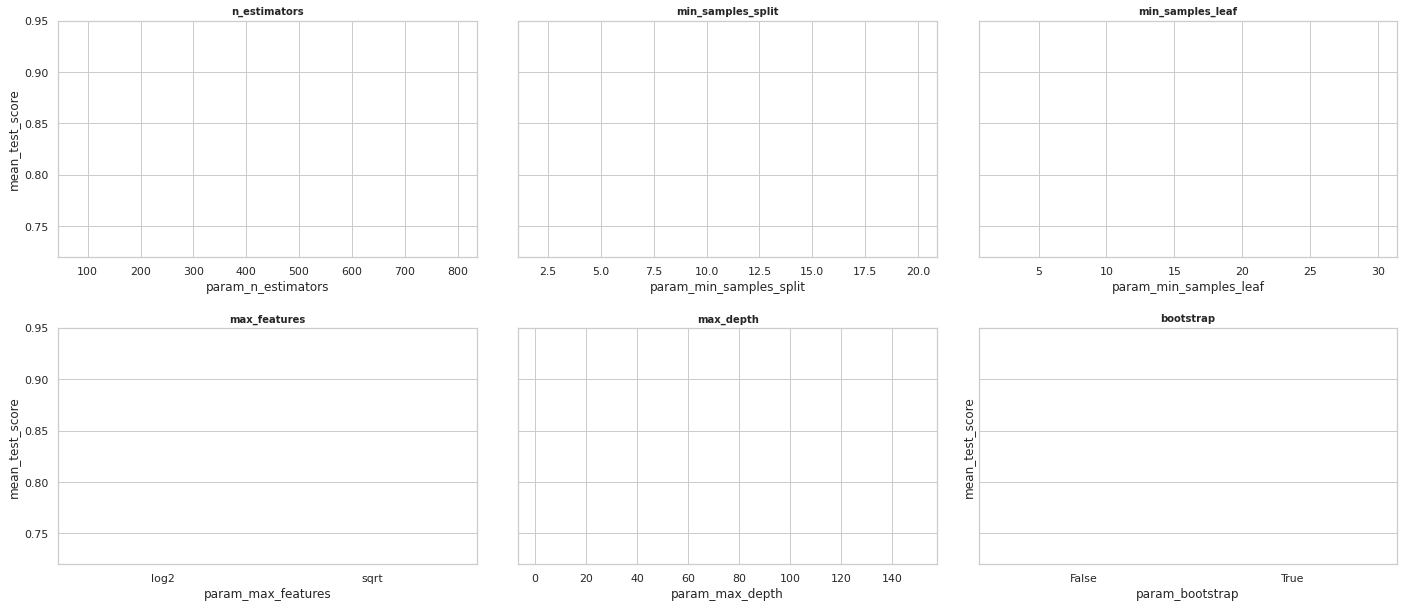

In [27]:
sns.set(style="whitegrid", color_codes=True, font_scale = 1)
fig, axs = plt.subplots(ncols=3, nrows=2  , sharey=True)
fig.set_size_inches(24,10)
colors = sns.diverging_palette(240, 0, n=6 , center='dark')
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0],color=colors[5]) 
axs[0,0].set_ylim([.72,.95])
axs[0,0].set_title(label = 'n_estimators', size=10, weight='bold')
sns.lineplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1],color=colors[4])
#axs[0,1].set_ylim([.85,.93])
axs[0,1].set_title(label = 'min_samples_split', size=10, weight='bold')
sns.lineplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2],color=colors[3])
#axs[0,2].set_ylim([.80,.93])
axs[0,2].set_title(label = 'min_samples_leaf', size=10, weight='bold')
sns.boxplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0],color=colors[0])
#axs[1,0].set_ylim([.88,.92])
axs[1,0].set_title(label = 'max_features', size=10, weight='bold')
sns.lineplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1],color=colors[1])
#axs[1,1].set_ylim([.80,.93])
axs[1,1].set_title(label = 'max_depth', size=10, weight='bold')
sns.boxplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2] , color=colors[2])
#axs[1,2].set_ylim([.88,.92])
axs[1,2].set_title(label = 'bootstrap', size=10, weight='bold')
fig.subplots_adjust(wspace=0.1 , hspace=0.3)

plt.show()


### Result
> Best Model Parameters
```

{'n_estimators': 288,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 150,
 'bootstrap': False}
```
> Best Parameter values

```
{'n_estimators': [136 , 309 , 347,385],
 'min_samples_split': [7,12,44],
 'min_samples_leaf': [2,7,12],
 'max_features': 'sqrt',
 'max_depth': [43 ,85, 100],
 'bootstrap': False}
```

## Grid Search

In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
n_estimators = [140 , 170 , 230]
max_features = ['sqrt'] 
bootstrap = [False]
max_depth =  [56 ,85, 100]
min_samples_leaf = [2,12]
min_samples_split = [7,18,28]

In [ ]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [ ]:
gs = GridSearchCV(rfc_v2 , param_grid , cv=5 , verbose=5 , n_jobs=-1)
gs.fit(data_val , data_label)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [56, 85, 100],
                         'max_features': ['sqrt'], 'min_samples_leaf': [2, 12],
                         'min_samples_split': [7, 18, 28],
                         'n_estimators': [140, 170, 230]},
             verbose=5)

In [ ]:
gs.best_params_

{'bootstrap': False,
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 18,
 'n_estimators': 140}

# Best Random Forest

So Now we have identified best random Forest , lets see how its various performance are.

## Load Data

In [272]:
np.random.seed(433)
data = data.sample(frac=1)


In [273]:
data_label = data['class']
x = data.copy()
y = data_label.copy()

## Train and save model

{'n_estimators': 402,
 'min_samples_split': 16,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 12,
 'bootstrap': False}

In [275]:
# Find and fit besst model
train_acc = []
test_acc = []
best_clf = ''
score = 0 
for i in tqdm(range(1)):
    rs = int(np.random.uniform(10 , 99999))
    '''
    27601 0.958974358974359
    79324
    '''
    np.random.seed(rs)
    rs = 31544 # all
    #rs = 31374 # CV-XRB 
    #rs = 65845 # xrb-pulsar
    #rs = 59360 #cv-pulsar
    rs = 31544 # NS-BH

    df =  x.sample(frac=1 , random_state=rs)
    y = df['class']
    x_train , x_test , _ , _ = train_test_split(df , y , test_size=0.1 , shuffle=True, random_state=10 , stratify=y)
    info_col = ['src_n' , 'src_id' , 'significance' , 'class']
    id_train = x_train[info_col]
    id_test = x_test[info_col]
    y_train = x_train['class']
    y_test = x_test['class']
    x_train = x_train.drop(info_col , axis=1)
    x_test = x_test.drop(info_col , axis = 1 )
    #np.random.seed(5926)
    clf = RandomForestClassifier(
        n_estimators= 400 , 
        criterion='entropy' ,
        random_state=12,
        max_depth=85 , 
        min_samples_leaf= 2 , 
        min_samples_split=2 , 
        bootstrap=False ,
        max_features='sqrt' ,
        class_weight='balanced'
        )
    clf.fit(x_train , y_train)
    tr = clf.score(x_train , y_train)
    next_score = clf.score(x_test , y_test)
    if(next_score > score):
        best_clf = clf
        score = next_score
        print('better found' , rs , next_score)
    #print(next_score , score)
    #print('\n -----------------')
    #print(rs , tst)
    ##train_acc.append(tr)
    #test_acc.append(tst)

100%|██████████| 1/1 [00:05<00:00,  5.26s/it]

better found 31544 0.8290598290598291


In [276]:
test_score =  best_clf.score(x_test , y_test)
print(test_score)

0.8290598290598291


### Test performance

In [277]:
info_col = ['src_n' , 'src_id' , 'significance' , 'class']
x_val = test_data[test_data['class'].isin(class_to_select)]
y_val = x_val['class']
x_val = x_val.drop(columns=info_col)
x_val 

photflux_aper_lolim_m  photflux_aper_lolim_h  \
obs_id                                                         
BH_OBS_34                   -5.165516              -5.041341   
BH_OBS_143                  -6.832162              -5.577410   
BH_OBS_153                  -6.719873              -6.298173   
BH_OBS_11                   -5.267204              -5.128369   
BH_OBS_151                  -6.690640              -5.503347   
...                               ...                    ...   
PULSAR_OBS_258              -6.406032              -4.887395   
PULSAR_OBS_20               -5.726304              -6.392223   
PULSAR_OBS_55               -4.174055              -4.600153   
PULSAR_OBS_273              -5.934794              -3.752763   
PULSAR_OBS_58               -4.118901              -4.728391   

                photflux_aper_hilim_s  photflux_aper_hilim_b  \
obs_id                                                         
BH_OBS_34                   -5.176982              -4.391367   
BH_OBS_143                  -7.024338              -5.247260   
BH_OBS_153                  -6.060381              -5.294051   
BH_OBS_11                   -5.555799              -4.617263   
BH_OBS_151                  -6.012512              -4.957424   
...                               ...                    ...   
PULSAR_OBS_258              -6.119358              -4.650140   
PULSAR_OBS_20               -4.934794              -4.799150   
PULSAR_OBS_55               -3.654822              -3.357634   
PULSAR_OBS_273              -6.188559              -3.677574   
PULSAR_OBS_58               -3.509901              -3.214813   

                photflux_aper_lolim_u  photflux_aper_hilim_m  \
obs_id                                                         
BH_OBS_34                   -6.774652              -4.971022   
BH_OBS_143                  -6.010404              -6.446755   
BH_OBS_153                  -6.024074              -6.258848   
BH_OBS_11                   -5.918653              -5.145937   
BH_OBS_151                  -5.185870              -6.255551   
...                               ...                    ...   
PULSAR_OBS_258              -5.568703              -6.887060   
PULSAR_OBS_20               -5.302302              -5.437469   
PULSAR_OBS_55               -3.262489              -4.143513   
PULSAR_OBS_273              -6.042968              -5.767258   
PULSAR_OBS_58               -3.235077              -4.089109   

                photflux_aper_hilim_u  photflux_aper_u  photflux_aper_h  \
obs_id                                                                    
BH_OBS_34                   -5.857298        -6.122862        -4.925549   
BH_OBS_143                  -5.395126        -5.676525        -5.469672   
BH_OBS_153                  -5.483529        -5.678245        -5.635449   
BH_OBS_11                   -5.053499        -5.298950        -5.062432   
BH_OBS_151                  -4.326058        -5.082991        -5.253521   
...                               ...              ...              ...   
PULSAR_OBS_258              -4.965773        -5.133936        -4.840433   
PULSAR_OBS_20               -4.900224        -5.066302        -5.987585   
PULSAR_OBS_55               -3.230770        -3.246340        -4.567833   
PULSAR_OBS_273              -5.189096        -5.425737        -3.743523   
PULSAR_OBS_58               -3.212185        -3.223517        -4.688670   

                photflux_aper_hilim_h  ...  var_index  hard_ms_hilim  \
obs_id                                 ...                             
BH_OBS_34                   -4.839231  ...   0.250000       0.425400   
BH_OBS_143                  -5.387958  ...   1.000000       0.215526   
BH_OBS_153                  -5.384366  ...   0.086167       0.164300   
BH_OBS_11                   -5.005199  ...   0.750000       0.600200   
BH_OBS_151                  -5.095880  ...   0.558167       0.106800   
...                               ...

In [280]:
test_score =  best_clf.score(x_val , y_val)
print(test_score)

0.8854961832061069


In [281]:
test_data[test_data['class'].isin(class_to_select)]

class                 src_n  src_id  significance  \
obs_id                                                               
BH_OBS_34          XRB  XTE J1550-564         BH0010         29.24   
BH_OBS_143         XRB  J1745-2900            BH0027        337.00   
BH_OBS_153         XRB  J1745-2900            BH0027        337.00   
BH_OBS_11          XRB  GINGA 1354-645        BH0003         20.86   
BH_OBS_151         XRB  J1745-2900            BH0027        337.00   
...                ...                   ...     ...           ...   
PULSAR_OBS_258  PULSAR        PSR J1745-2900  PL0081        107.91   
PULSAR_OBS_20   PULSAR        PSR J0101-6422  PL0004          4.89   
PULSAR_OBS_55   PULSAR        PSR J0437-4715  PL0012        113.03   
PULSAR_OBS_273  PULSAR        PSR J1745-2900  PL0081        107.91   
PULSAR_OBS_58   PULSAR        PSR J0437-4715  PL0012        113.03   

                photflux_aper_lolim_m  photflux_aper_lolim_h  \
obs_id                                                         
BH_OBS_34                   -5.165516              -5.041341   
BH_OBS_143                  -6.832162              -5.577410   
BH_OBS_153                  -6.719873              -6.298173   
BH_OBS_11                   -5.267204              -5.128369   
BH_OBS_151                  -6.690640              -5.503347   
...                               ...                    ...   
PULSAR_OBS_258              -6.406032              -4.887395   
PULSAR_OBS_20               -5.726304              -6.392223   
PULSAR_OBS_55               -4.174055              -4.600153   
PULSAR_OBS_273              -5.934794              -3.752763   
PULSAR_OBS_58               -4.118901              -4.728391   

                photflux_aper_hilim_s  photflux_aper_hilim_b  \
obs_id                                                         
BH_OBS_34                   -5.176982              -4.391367   
BH_OBS_143                  -7.024338              -5.247260   
BH_OBS_153                  -6.060381              -5.294051   
BH_OBS_11                   -5.555799              -4.617263   
BH_OBS_151                  -6.012512              -4.957424   
...                               ...                    ...   
PULSAR_OBS_258              -6.119358              -4.650140   
PULSAR_OBS_20               -4.934794              -4.799150   
PULSAR_OBS_55               -3.654822              -3.357634   
PULSAR_OBS_273              -6.188559              -3.677574   
PULSAR_OBS_58               -3.509901              -3.214813   

                photflux_aper_lolim_u  photflux_aper_hilim_m  ...  var_index  \
obs_id                                                        ...              
BH_OBS_34                   -6.774652              -4.971022  ...   0.250000   
BH_OBS_143                  -6.010404              -6.446755  ...   1.000000   
BH_OBS_153                  -6.024074              -6.258848  ...   0.086167   
BH_OBS_11                   -5.918653              -5.145937  ...   0.750000   
BH_OBS_151                  -5.185870              -6.255551  ...   0.558167   
...                               ...                    ...  ...        ...   
PULSAR_OBS_258              -5.568703              -6.887060  ...   0.000000   
PULSAR_OBS_20               -5.302302              -5.437469  ...   0.000000   
PULSAR_OBS_55               -3.262489              -4.143513  ...   0.000000   
PULSAR_OBS_273              -6.042968              -5.767258  ...   9.666667   
PULSAR_OBS_58               -3.235077              -4.089109  ...   0.000000   

                hard_ms_hilim  hard_hm_lolim  hard_hs  hard_ms_lolim  \
obs_id                                                                 
BH_OBS_34            0.425400      -0.000600   0.4035       0.099300   
BH_OBS_143           0.215526       0.500569   0.9994      -0.481066   
BH_OBS_153           0.164300       0.624000   0.9994      -1.000000   
BH_OBS_11            0.600200       0.0

### Save model


In [282]:
import joblib 
joblib.dump(best_clf , 'forest/v2/all-clf.joblib' , compress=3)

['forest/v2/all-clf.joblib']

### Entropy-Wise Feature Importance

In [283]:
feat_imp = clf.feature_importances_
feat_names = x_train.columns.to_list()
feat = pd.DataFrame()
feat.insert( 0 , 'feat_name' , feat_names)
feat.insert(1 , 'feat_imp' , feat_imp)
feat = feat.sort_values(by = 'feat_imp' , ascending=False).reset_index(drop=True)
feat_names_sorted = feat['feat_name']
display(feat)
#feat.to_csv('result/feat_imp.csv')

feat_name  feat_imp
0           hard_hs_lolim  0.039034
1               var_sigma  0.034607
2                 var_min  0.032771
3                var_mean  0.031491
4             flux_aper_u  0.029297
5                var_prob  0.028266
6   photflux_aper_lolim_u  0.027865
7                 hard_hs  0.027018
8           hard_hs_hilim  0.026330
9   photflux_aper_lolim_b  0.026302
10      flux_aper_lolim_u  0.026270
11    photflux_aper_lolim  0.025060
12      flux_aper_hilim_u  0.024987
13        photflux_aper_u  0.024583
14          hard_hm_hilim  0.022934
15      flux_aper_lolim_h  0.022686
16            flux_aper_h  0.022331
17                var_max  0.022216
18  photflux_aper_lolim_h  0.020369
19  photflux_aper_hilim_u  0.020263
20        photflux_aper_b  0.019470
21        photflux_aper_s  0.019335
22      flux_aper_hilim_s  0.018780
23            flux_aper_s  0.018344
24        flux_aper_lolim  0.018252
25      flux_aper_hilim_h  0.017711
26                hard_hm  0.017109
27  photflux_aper_lolim_s  0.016827
28          hard_hm_lolim  0.016705
29  photflux_aper_lolim_m  0.016552
30      flux_aper_lolim_b  0.016516
31  photflux_aper_hilim_s  0.015888
32        photflux_aper_h  0.015520
33          photflux_aper  0.015497
34  photflux_aper_hilim_h  0.015449
35          hard_ms_lolim  0.014244
36      flux_aper_lolim_m  0.014210
37                hard_ms  0.014071
38      flux_aper_lolim_s  0.013629
39    photflux_aper_hilim  0.013385
40          hard_ms_hilim  0.013229
41                kp_prob  0.011928
42  photflux_aper_hilim_m  0.011134
43  photflux_aper_hilim_b  0.010998
44                ks_prob  0.010725
45            flux_aper_m  0.010720
46        flux_aper_hilim  0.010704
47              flux_aper  0.010321
48              var_index  0.010272
49      flux_aper_hilim_m  0.010138
50            flux_aper_b  0.009423
51        photflux_aper_m  0.009268
52      flux_aper_hilim_b  0.008964

## Bake Result

### Function

In [217]:
def create_res_data(x , y , id_data  , cl_type):
    pred = clf.predict(x)
    pred_prob = np.asarray(clf.predict_proba(x))
    pred_prob_xrb = pred_prob[:,0]
    pred_prob_cv = pred_prob[:,1]
    #pred_prob_pulsar = pred_prob[:,2]
    pred_prob = [np.amax(pi) for pi in pred_prob]
    res =  x.copy()
    res = res[feat_names_sorted]
    #id_data = id_data.reset_index(drop=True)
    res.insert(0 , 'clf_type' , [cl_type]*len(res))
    res.insert(1 , 'true_class' , y)
    res.insert(2 ,'pred_class' , pred)
    res.insert(3 , 'pred_prob' , pred_prob)
    res.insert(4 , 'CV_prob' , pred_prob_xrb)
    res.insert(5 , 'XRB_prob' , pred_prob_cv)
    #res.insert(5 , 'PULSAR_prob' , pred_prob_pulsar)
    res = pd.concat([id_data , res] , axis=1).drop('class' , axis=1)
    truth = []
    th_class = [] 
    is_ok = [] 
    for tc , pc , pp in zip(res['true_class'] , res['pred_class'] , res['pred_prob']):
        if(tc==pc): is_ok.append(1)
        else: is_ok.append(0)
        if(pp > 0.6):
            th_class.append(pc)
            if(tc==pc):
                truth.append(1)
            else: truth.append(0)
        else :
            truth.append(2)
            th_class.append('X')
    res.insert(5 , 'th_class' , th_class )
    res.insert(6 , 'truth' , truth)
    res.insert(6 , 'is_ok' , is_ok)
    return res


### Bake it

In [284]:

train_res = create_res_data(x_train , y_train ,id_train , cl_type='train')
test_res = create_res_data(x_test , y_test ,id_test , cl_type='test')
#train_res.to_csv('result/train_res_rf.csv')
#test_res.to_csv('result/test_res_rf.csv')
res_data = pd.concat([test_res])
#res_data =  res_data.set_index('obs_id')
#res_data.to_csv('../result/res_rf_tuned_rf_impute.csv')

# Result Analysis

In [285]:
cv_data = res_data[res_data['true_class']=='CV']
cv_sources = np.unique(cv_data['src_id'])
print('Num of CV sources :' , len(cv_sources))
print('Num of CV obs :' , len(cv_data))

cv_data = res_data[res_data['true_class']=='XRB']
cv_sources = np.unique(cv_data['src_id'])
print('Num of LMXRB sources :' , len(cv_sources))
print('Num of LMXRB obs :' , len(cv_data))

cv_data = res_data[res_data['true_class']=='PULSAR']
cv_sources = np.unique(cv_data['src_id'])
print('Num of PULSAR sources :' , len(cv_sources))
print('Num of PULSAR obs :' , len(cv_data))

Num of CV sources : 29
Num of CV obs : 47
Num of LMXRB sources : 22
Num of LMXRB obs : 41
Num of PULSAR sources : 24
Num of PULSAR obs : 29


In [286]:
data =  res_data.copy().query('clf_type=="test"')
#print(data)
total = len(data)
print('Total samples' , total)
am_clf = len(data[data['th_class']=='X'])
print('Ambiguous calssification : ' , am_clf)
wrong_clf = len(data[data['truth']==0])
print('Wrong calssification : ' , wrong_clf)

acc = (total-am_clf-wrong_clf)/total
print('Classification accuracy :{:.3f}'.format(acc))

Total samples 117
Ambiguous calssification :  28
Wrong calssification :  10
Classification accuracy :0.675


In [287]:
res_data_amb = res_data[res_data['th_class']=='X']
res_data_amb['true_class'].value_counts()

CV        14
XRB        9
PULSAR     5
Name: true_class, dtype: int64

## ROC Curve

In [262]:
from sklearn.metrics import roc_curve , det_curve , roc_auc_score

/home/kumaran/.local/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:319: RuntimeWarning: invalid value encountered in true_divide
  fns[sl][::-1] / p_count,


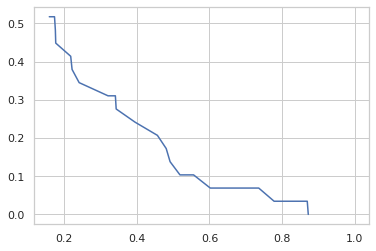

In [223]:
#fpr , fnr , threshold = det_curve(res_data['true_class'] , res_data['PULSAR_prob'] , pos_label='PULSAR')
#plt.plot(threshold , fpr)
fpr , fnr , threshold = det_curve(res_data['true_class'] , res_data['XRB_prob'] , pos_label='XRB')
plt.plot(threshold , fpr)
fpr , fnr , threshold = det_curve(res_data['true_class'] , res_data['CV_prob'] , pos_label='CV')
plt.plot(threshold , fpr)
plt.show()

In [164]:
roc_auc = roc_auc_score(res_data['true_class'] , res_data['XRB_prob'])
roc_auc

0.988793671720501

## Feature Importance

multiplying the average standardised mean value of each feature split on each class, with the corresponding model._feature_importances array element. You can write a simple function that standardises your dataset, computes the mean of each feature split across class predictions, and does element-wise multiplication with the model._feature_importances array. The greater the absolute resulting values are, the more important the features will be to their predicted class, and better yet, the sign will tell you if it is small or large values that are important.

https://stackoverflow.com/questions/35249760/using-scikit-to-determine-contributions-of-each-feature-to-a-specific-class-pred/35255612

In [88]:
from sklearn.preprocessing import scale
import json
def class_feature_importance(X, Y, feature_importances):
    N, M = X.shape
    X = scale(X)

    out = {}
    for c in set(Y):
        print(c)
        out[c] = dict(
            zip(range(M), np.mean(X[Y==c, :], axis=0)*feature_importances)
        )
    return out


In [89]:
feat_imp = best_clf.feature_importances_ 
result = class_feature_importance(x_train , y_train , feat_imp)
#print(json.dumps(result,indent=4))

CV
XRB


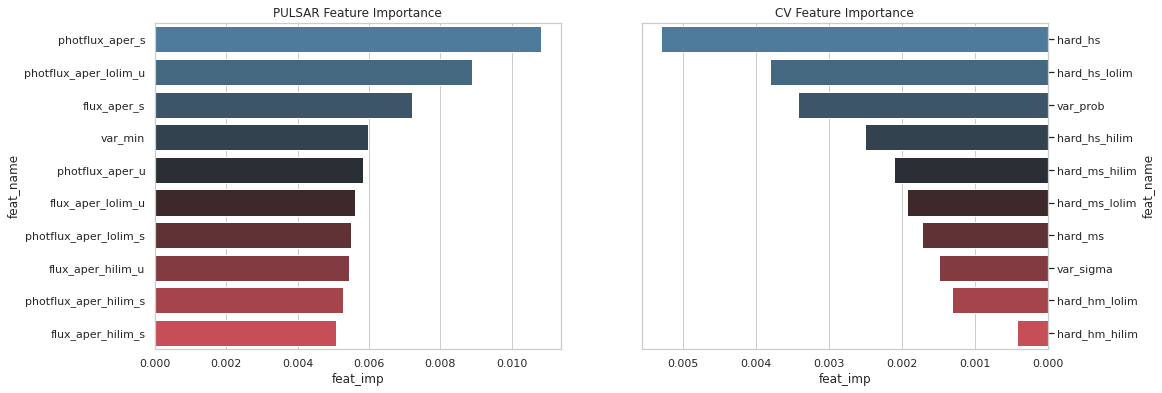

In [91]:
sns.set_style('whitegrid')
fig , ax = plt.subplots(nrows=1 , ncols=2 , figsize=(16,6))
feat_names = x_train.columns.to_list()
top_feat = 10
#result['BH'].keys() = feat_names
values = list(result['CV'].values())
df=  pd.DataFrame()
df.insert(0 , 'feat_name' , feat_names)
df.insert(1 , 'feat_imp' , values)
df = df.sort_values(by='feat_imp' , ascending=False)
df_feat_cla = df.copy() # cla - class A
palette = sns.diverging_palette(240, 10, n=top_feat , center='dark')
ax1 = sns.barplot(data = df.iloc[:top_feat,:] ,y = 'feat_name' , x = 'feat_imp'  ,palette = palette, ax=ax[0] )

values = list(result['XRB'].values())
df=  pd.DataFrame()
df.insert(0 , 'feat_name' , feat_names)
df.insert(1 , 'feat_imp' , values)
df = df.sort_values(by='feat_imp' , ascending=False)
df_feat_clb = df.copy() # clb - class B
palette = sns.diverging_palette(240, 10, n=top_feat , center='dark')
ax2 = sns.barplot(data = df.iloc[:top_feat,:] ,y = 'feat_name' , x = 'feat_imp'  ,palette = palette, ax=ax[1] )
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.invert_xaxis()
ax1.set_title('PULSAR Feature Importance')
ax2.set_title('CV Feature Importance')
plt.show()

In [92]:
def is_outlier(points, thresh):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = np.asarray(points)
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation    
    return modified_z_score > thresh

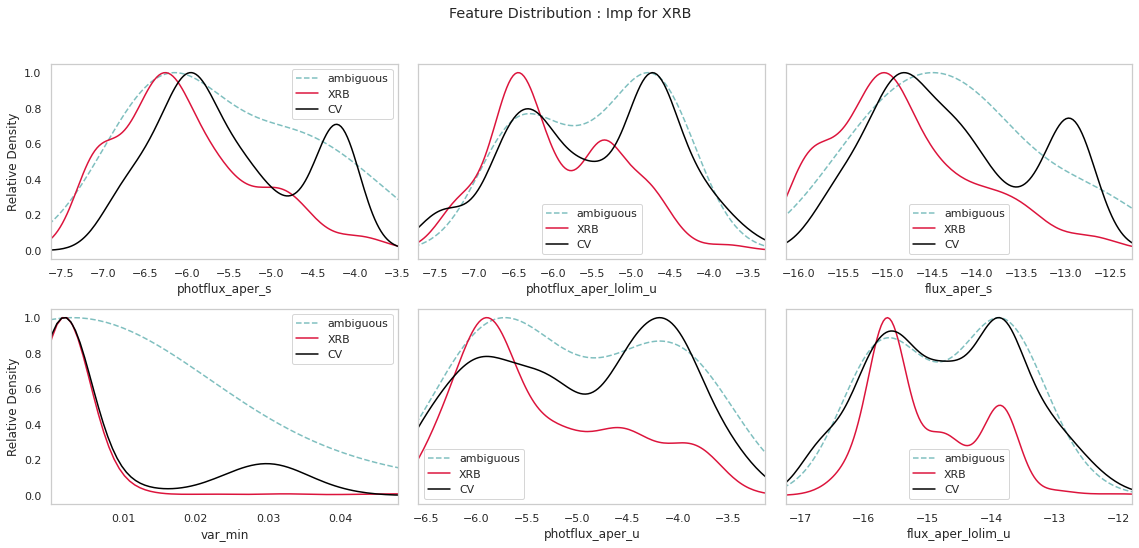

In [93]:
fig, axs = plt.subplots(2,3, sharey=True, sharex=False , figsize=(16 , 8))
col = sns.diverging_palette(240, 10, n=6 , center='dark')
f_name  =  df_feat_cla['feat_name'][:6]
axs = np.ndarray.flatten(axs)
sns.set_style('white')
i = 0 
for f , axi in zip(f_name , axs):
    if(f=='bb_nh_lolim'):
        filtered_res = res_data[~is_outlier(res_data[f] , thresh=150)]
    elif(f=='bb_nh'):
        filtered_res = res_data[~is_outlier(res_data[f] , thresh=100)]
    else:
        filtered_res = res_data[~is_outlier(res_data[f] , thresh=20)]
    #filtered_res = res_data.copy()
    #print(f)
    ax = sns.displot(data = res_data , x = f ,hue = 'true_class' , kind='kde' ,)
    plt.close()
    ax2 = sns.displot(data = res_data[res_data['th_class']=='X'] , x = f ,hue = 'th_class' , kind='kde' ,)
    plt.close()
    amb  , amb_x= ax2.ax.lines[0].get_ydata() , ax2.ax.lines[0].get_xdata()
    amb =  amb / np.amax(amb)
    bh  ,  bh_x = ax.ax.lines[0].get_ydata() , ax.ax.lines[0].get_xdata() 
    bh = bh /np.amax(bh) 
    ns , ns_x = ax.ax.lines[1].get_ydata() , ax.ax.lines[1].get_xdata()
    ns = ns/np.amax(ns)
    #x_val = ax.ax.lines[0].get_xdata() , ax.ax.lines[1].get_xdata()
    #plt.close()
    axi.plot(amb_x , amb , label = 'ambiguous' , color='teal' , alpha=0.5 , linestyle='--')
    axi.plot(ns_x , ns , label = 'XRB' , color='crimson')
    axi.plot(bh_x , bh , label = 'CV' , color = 'black')
    axi.legend()
    axi.set_xlim(np.amin(filtered_res[f]) , np.amax(filtered_res[f]))
    axi.grid(True , color='k' , linestyle=':' , alpha=0.4)
    axi.grid(False)
    axi.set_xlabel(f)
    #axi.set_xscale('log')
    if(not(i%3)):
        axi.set_ylabel('Relative Density')
    i+=1    
    #axi.text(0.1 , 0.1 ,  'Feature : '+f)
fig.suptitle('Feature Distribution : Imp for XRB')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.close()


/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Attempting to set identical left == right == 0.6392323144850272 results in singular transformations; automatically expanding.


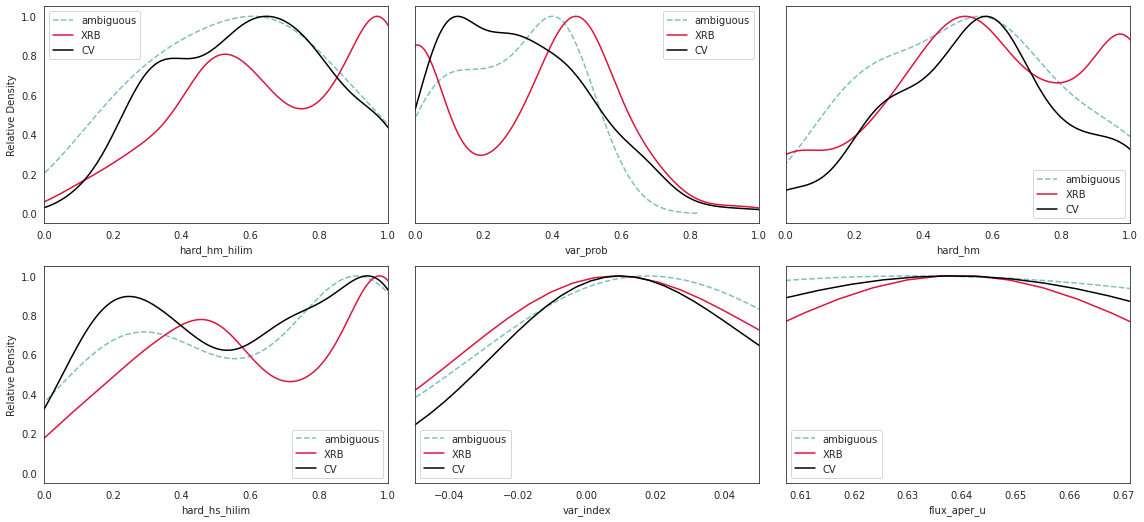

In [56]:
fig, axs = plt.subplots(2,3, sharey=True, sharex=False , figsize=(16 , 8))
col = sns.diverging_palette(240, 10, n=6 , center='dark')
f_name  =  df_feat_clb['feat_name'][:6]
axs = np.ndarray.flatten(axs)
sns.set_style('white')
i = 0 
for f , axi in zip(f_name , axs):
    if(f=='bb_stat'):
        filtered_res = res_data[~is_outlier(res_data[f] , thresh=650)]
    else:
        filtered_res = res_data[~is_outlier(res_data[f] , thresh=350)]
    #filtered_res = res_data.copy()
    #print(f)
    ax = sns.displot(data = res_data , x = f ,hue = 'true_class' , kind='kde' ,)
    plt.close()
    ax2 = sns.displot(data = res_data[res_data['th_class']=='X'] , x = f ,hue = 'th_class' , kind='kde' ,)
    plt.close()
    amb  , amb_x= ax2.ax.lines[0].get_ydata() , ax2.ax.lines[0].get_xdata()
    amb =  amb / np.amax(amb)
    bh  ,  bh_x = ax.ax.lines[0].get_ydata() , ax.ax.lines[0].get_xdata() 
    bh = bh /np.amax(bh) 
    ns , ns_x = ax.ax.lines[1].get_ydata() , ax.ax.lines[1].get_xdata()
    ns = ns/np.amax(ns)
    #x_val = ax.ax.lines[0].get_xdata() , ax.ax.lines[1].get_xdata()
    #plt.close()
    axi.plot(amb_x , amb , label = 'ambiguous' , color='teal' , alpha=0.5 , linestyle='--')
    axi.plot(ns_x , ns , label = 'XRB' , color='crimson')
    axi.plot(bh_x , bh , label = 'CV' , color = 'black')
    axi.legend()
    axi.set_xlim(np.amin(filtered_res[f]) , np.amax(filtered_res[f]))
    axi.grid(True , color='k' , linestyle=':' , alpha=0.4)
    axi.grid(False)
    axi.set_xlabel(f)
    #axi.set_xscale('log')
    if(not(i%3)):
        axi.set_ylabel('Relative Density')
    i+=1    
    #axi.text(0.1 , 0.1 ,  'Feature : '+f)
#fig.suptitle('Feature Distribution')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.close()
